# Analyze curated mutational counts

## Import Python modules

In [ ]:
import os
import pandas as pd
import numpy as np
import scipy.stats
import re
from collections import defaultdict
from Bio.Seq import Seq
from Bio import SeqIO
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_theme(font_scale=1.0, style='ticks', palette='colorblind')

## Read in counts data, compute fitness effects using old and new approaches, and read in data on gene boundaries

In [2]:
# Read in counts data and add columns giving truncated counts
counts_df = pd.read_csv('../results/curated_mut_counts.csv')
counts_df['mut_type_arrow'] = counts_df['mut_type'].apply(
    lambda x: x[0]+r'$\rightarrow$'+x[1]
)
counts_df['site'] = counts_df['nt_site']
counts_df['ss_paired'] = counts_df['ss_prediction'] == 'paired'

# Add new columns...
actual_count_cols = [
    'actual_count',
    'actual_count_England',
    'actual_count_USA',
    'actual_count_pre_omicron',
    'actual_count_omicron'
]
clipping_upper_lim = 0.98
dfs = []
for (mut_type, mut_type_data) in counts_df.groupby('mut_type'):
    
    # Add a column with actual counts truncated at the indicated percentile of the distribution
    # of counts for synonymous mutations
    syn_data = mut_type_data[mut_type_data['mut_class'] == 'synonymous'].copy()
    for actual_count_col in actual_count_cols:
        upper_lim = syn_data[actual_count_col].quantile(clipping_upper_lim)
        syn_data[f'truncated_{actual_count_col}'] = syn_data[actual_count_col].clip(upper=upper_lim)
        mut_type_data[f'truncated_{actual_count_col}'] = mut_type_data[actual_count_col].clip(upper=upper_lim)

    # Add columns with expected counts computed from the curated counts data
    mut_type_data['expected_count_mean'] = syn_data['actual_count'].mean()
    mut_type_data['expected_count_mean_truncated'] = syn_data['truncated_actual_count'].mean()
    mut_type_data['expected_count_median'] = syn_data['actual_count'].median()

    # Add columns of counts shuffled between mutations within the same class (syn, nonsyn, nonsense, noncoding)
    for (mut_class, mut_class_data) in mut_type_data.groupby('mut_class'):
        mut_class_data['shuffled_actual_count'] = list(mut_class_data['actual_count'].sample(frac=1, random_state=1))
        mut_class_data['shuffled_truncated_actual_count'] = list(mut_class_data['truncated_actual_count'].sample(frac=1, random_state=1))
        dfs.append(mut_class_data)

counts_df = pd.concat(dfs)

# Compute fitness values using multiple different strategies
counts_df['fitness'] = counts_df.apply(
    lambda row: np.log((row['actual_count'] + 0.5) / (row['expected_count'] + 0.5)),
    axis=1
)
counts_df['fitness_mean'] = counts_df.apply(
    lambda row: np.log((row['actual_count'] + 0.5) / (row['expected_count_mean'] + 0.5)),
    axis=1
)
counts_df['fitness_mean_truncated'] = counts_df.apply(
    lambda row: np.log((row['actual_count'] + 0.5) / (row['expected_count_mean_truncated'] + 0.5)),
    axis=1
)
counts_df['fitness_median'] = counts_df.apply(
    lambda row: np.log((row['actual_count'] + 0.5) / (row['expected_count_median'] + 0.5)),
    axis=1
)

# Read in gene boundaries
gene_boundaries_df = pd.read_csv('../results/gene_boundaries.csv')

## Plot distributions of counts

Make a plot that summarizes for each mutation type the number of sites being analyzed and the distribution of synonymous mutation counts for that set of sites.

truncated_actual_count


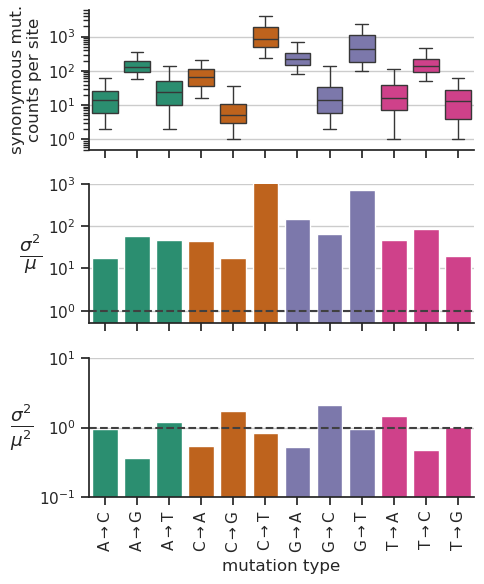

In [3]:
counts_var = 'truncated_actual_count'
print(counts_var)
mean_counts_df = counts_df[
    counts_df['mut_class'] == 'synonymous'
].groupby('mut_type', as_index=False).agg(
    mean = (counts_var, 'mean'),
    var = (counts_var, 'var'),
    std = (counts_var, 'std'),
    n = ('mut_type', 'count')
)
mean_counts_df['var_over_mean'] = mean_counts_df['var'] / mean_counts_df['mean']
mean_counts_df['var_over_mean2'] = mean_counts_df['var'] / np.power(mean_counts_df['mean'], 2)
mean_counts_df['std_over_mean'] = mean_counts_df['std'] / mean_counts_df['mean']
mean_counts_df['mut_type_arrow'] = mean_counts_df['mut_type'].apply(
    lambda x: x[0]+r'$\rightarrow$'+x[1]
)
mean_counts_df['wt_nt'] = mean_counts_df['mut_type'].apply(lambda x: x[0])
mut_order = mean_counts_df['mut_type_arrow'].unique()

# Plot data
(fig, axs) = plt.subplots(nrows=3, sharex=True, figsize=[5,6])
mut_type_pal = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']

# Plot counts distributions
data = counts_df[counts_df['mut_class'] == 'synonymous'].copy()
sns.boxplot(
    x='mut_type_arrow', y=counts_var, data=data, whis=(5,95), showfliers=False,
    order=mut_order, ax=axs[0],
    hue='wt_nt', dodge=False, palette=mut_type_pal
)
axs[0].set(
    xlabel='', ylabel=f'synonymous mut.\ncounts per site', yscale='log',
    ylim=[0.5, 6e3], yticks=[1, 1e1, 1e2, 1e3]
)

# Plot variance over mean
sns.barplot(
    x='mut_type_arrow', y='var_over_mean', data=mean_counts_df,
    order=mut_order, ax=axs[1],
    hue='wt_nt', dodge=False, palette=mut_type_pal, #color='0.5',
)
axs[1].axhline(1, ls='--', c='0.25')
axs[1].set(
    xlabel='mutation type', ylabel=r'$\frac{{\sigma^2}}{{\mu}}$', yscale='log',
    ylim=[0.5, 1e3]
)
axs[1].minorticks_off()
axs[1].yaxis.label.set(rotation='horizontal', va='center', ha='right', fontsize=19)

# Plot variance over mean squared
sns.barplot(
    x='mut_type_arrow', y='var_over_mean2', data=mean_counts_df,
    order=mut_order, ax=axs[2],
    hue='wt_nt', dodge=False, palette=mut_type_pal, #color='0.5',
)
axs[2].axhline(1, ls='--', c='0.25')
axs[2].set(
    xlabel='mutation type', ylabel=r'$\frac{{\sigma^2}}{{\mu^2}}$',
    yscale='log', ylim=[0.1, 1e1]
)
axs[2].minorticks_off()
axs[2].yaxis.label.set(rotation='horizontal', va='center', ha='right', fontsize=19)
axs[2].tick_params('x', labelrotation=90)

for i in [0, 1, 2]:
    axs[i].grid(axis='y')
    axs[i].get_legend().remove()
plt.tight_layout()
sns.despine()
plt.show()

Show the number of analyzed sites per mutation type

In [4]:
display(mean_counts_df[['mut_type', 'n']])
# print(
#     mean_counts_df[['mut_type_arrow', 'n']]
#     .rename(columns={'mut_type_arrow' : 'mutation type', 'n' : 'number of sites'})
#     .to_latex(index=False, label='n_sites', formatters={'number of sites' : '{:,.0f}'}, column_format='cc')
# )

,mut_type,n
0,AC,1479
1,AG,2426
2,AT,1291
3,CA,649
4,CG,532
5,CT,1539
6,GA,862
7,GC,261
8,GT,261
9,TA,2280


For each mutation type, compare the distribution of counts for synonymous, nonsynonymous, and stop mutations

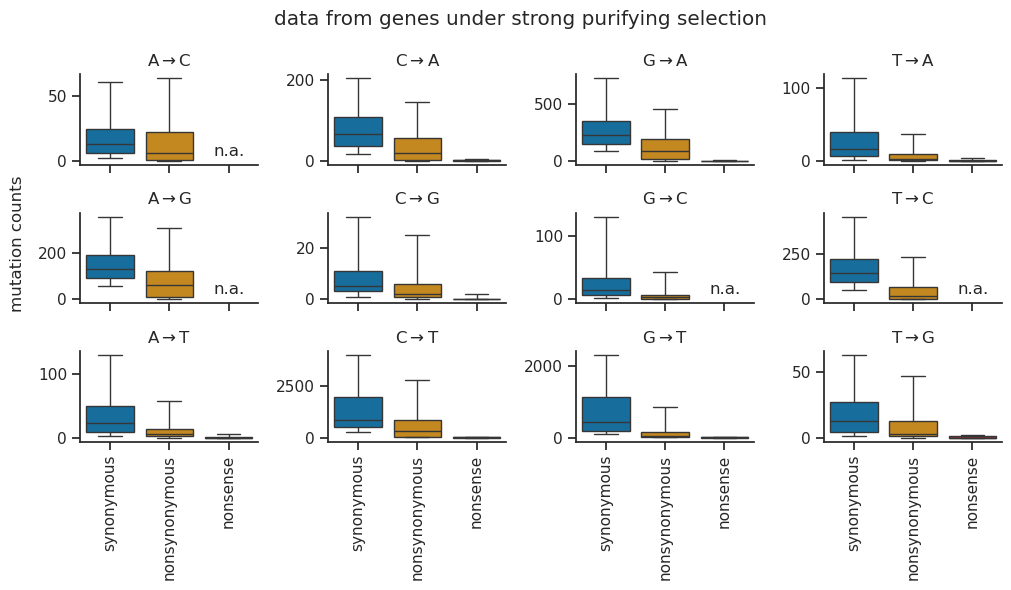

In [5]:
mut_class_colors = {
    'synonymous' : '#0173b2',
    'nonsynonymous' : '#de8f05',
    'nonsense' : 'firebrick',
    'noncoding' : 'darkviolet',
}
counts_var = 'truncated_actual_count'
order = [
    'synonymous',
    'nonsynonymous', 'nonsense'
]
(fig, axs) = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=False, figsize=[10,6])
axs = axs.reshape(-1, order='F')

data = counts_df[counts_df['gene'].isin(['ORF1a;ORF1ab', 'ORF1ab', 'S', 'E', 'M', 'N'])]

for i, (mut_type, mut_data) in enumerate(data.groupby('mut_type_arrow')):

    # print(mut_type.replace('$\\rightarrow$', ''), mut_data['mut_class'].value_counts())

    sns.boxplot(
        x='mut_class', y=counts_var, data=mut_data,
        order=order, hue='mut_class', hue_order=order, palette=mut_class_colors,
        whis=(5,95),# whis=(0,100), # 
        showfliers=False, ax=axs[i]
    )
    if sum(mut_data['mut_class'] == 'nonsense') == 0:
        axs[i].annotate('n.a.', (0.75, 0.1), xycoords=axs[i].transAxes)
    axs[i].set(title=mut_type, xlabel='', ylabel='')
    axs[i].tick_params(axis='x', labelrotation=90)

fig.text(-0.01, 0.59, 'mutation counts', va='center', rotation='vertical')
plt.suptitle('data from genes under strong purifying selection')
plt.tight_layout()
sns.despine()
plt.show()

Across sites where a given pair of mutation types both result in synonymous mutations, is there a correlation in counts between mutation types?

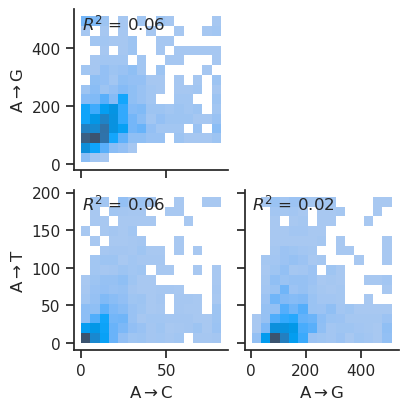

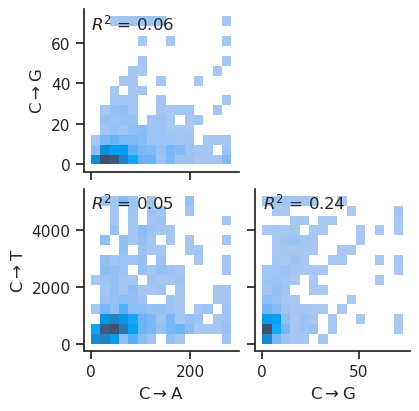

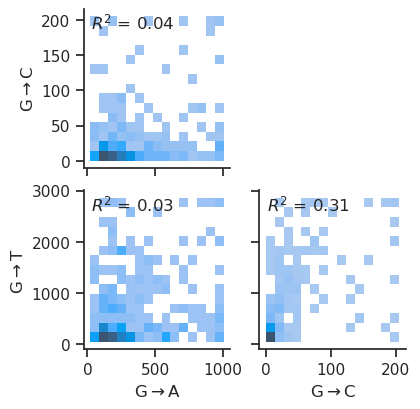

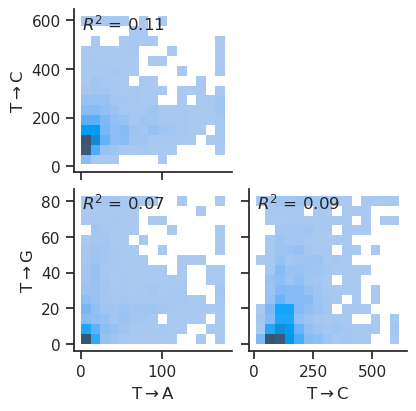

In [6]:
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = scipy.stats.pearsonr(x, y)
    r2 = math.pow(r, 2)
    ax = ax or plt.gca()
    ax.annotate('$R^2$' + f' = {r2:.2f}', xy=(.05, .875), xycoords=ax.transAxes)

counts_var = 'truncated_actual_count'
data = counts_df[
    (counts_df['mut_class'] == 'synonymous')
].pivot(index='site', columns='mut_type', values=counts_var)
mut_sets = [
    ['AC', 'AG', 'AT'],
    ['CA', 'CG', 'CT'],
    ['GA', 'GC', 'GT'],
    ['TA', 'TC', 'TG']
]
for mut_set in mut_sets:
    g = sns.pairplot(
        data[mut_set].dropna().rename(columns={x:x[0]+r'$\rightarrow$'+x[1] for x in mut_set}),
        corner=True, kind='hist',
        plot_kws={'bins':15},
        height=2
    )
    g.map_lower(corrfunc)
    for ax in g.diag_axes:
        ax.set_visible(False)
    for i, y_var in enumerate(g.y_vars):
        for j, x_var in enumerate(g.x_vars):
            if x_var == y_var:
                g.axes[i, j].set_visible(False)
    plt.show()

Plot the distribution of counts as a function of primary sequence, using a sliding window to smooth the data

counts_var truncated_actual_count
window size 2001
AC


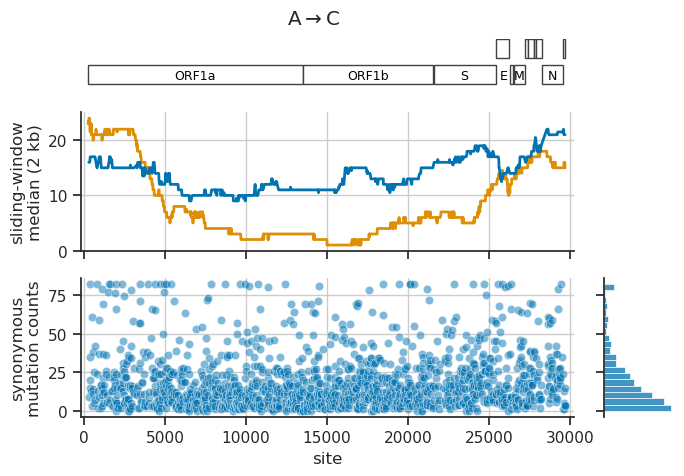

AG


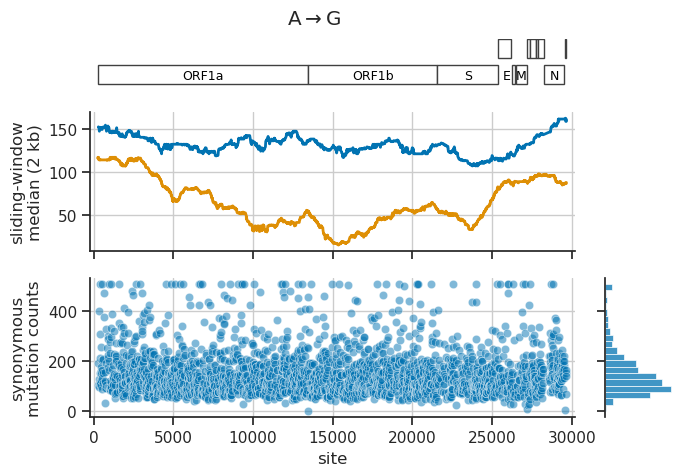

AT


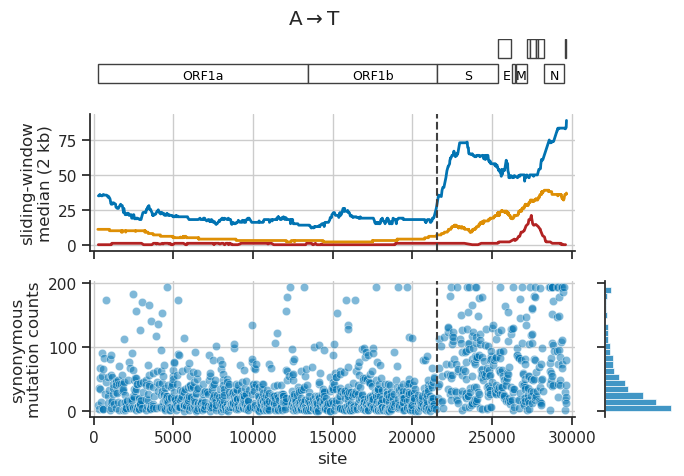

CA


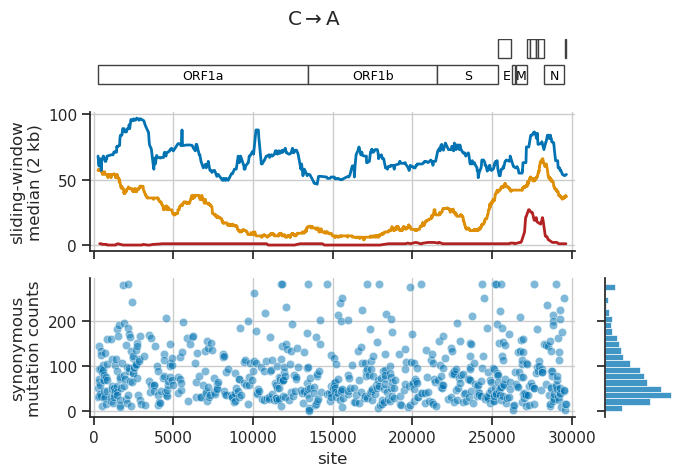

CG


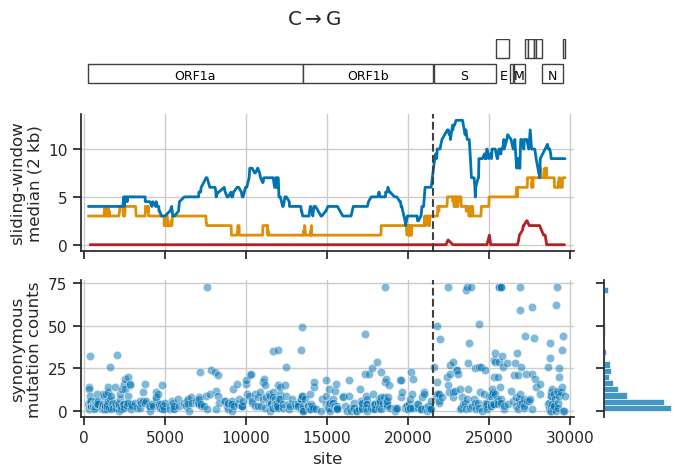

CT


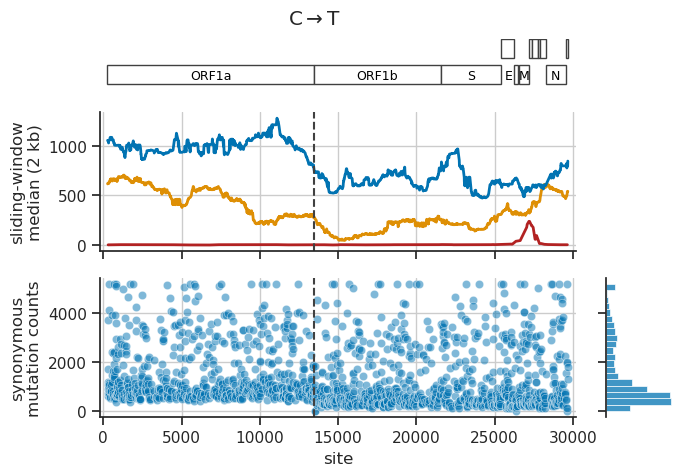

GA


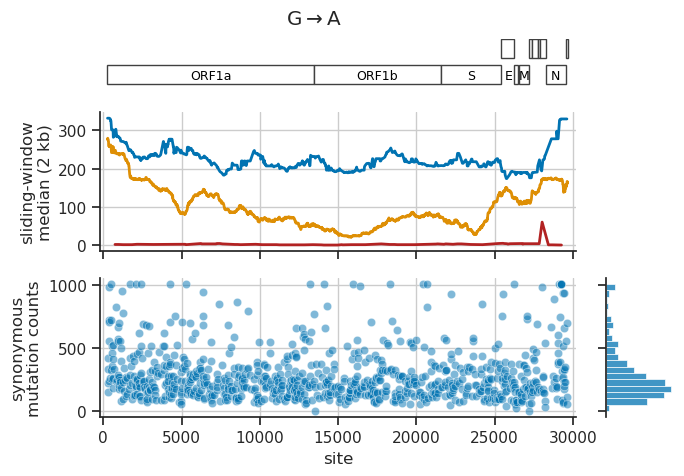

GC


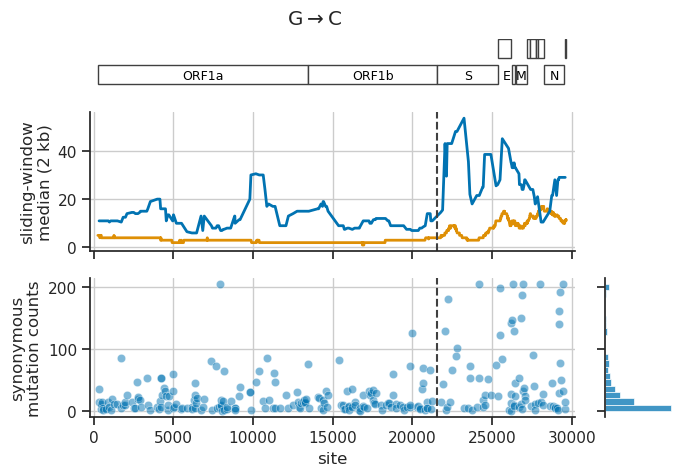

GT


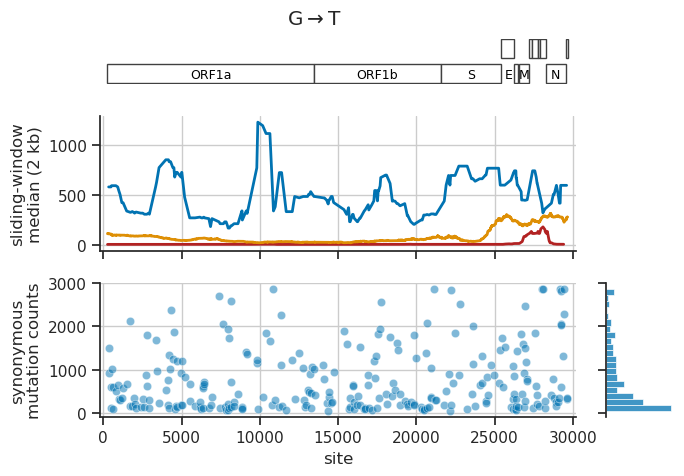

TA


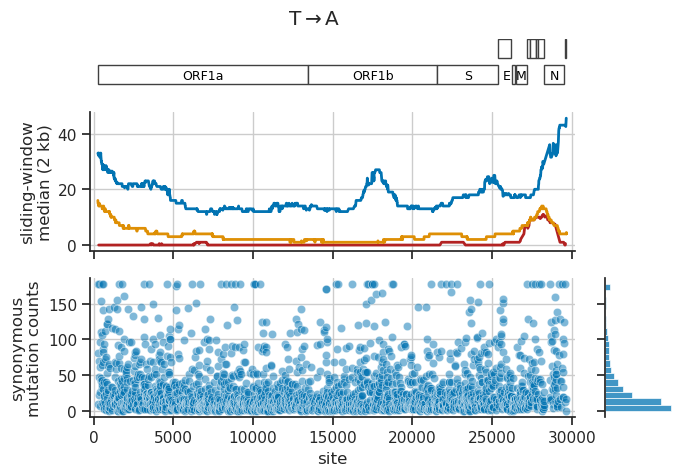

TC


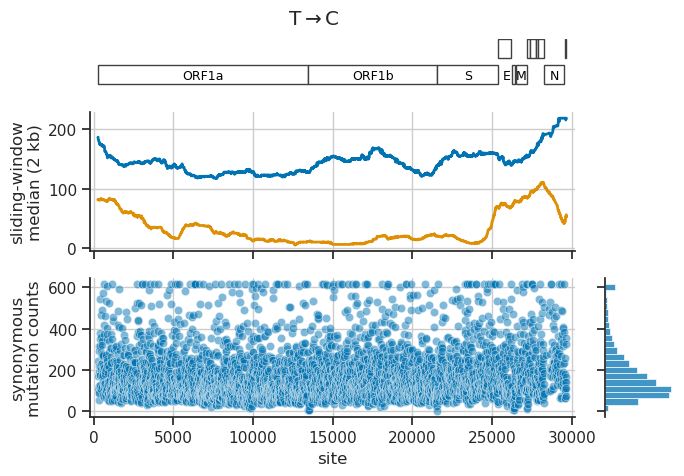

TG


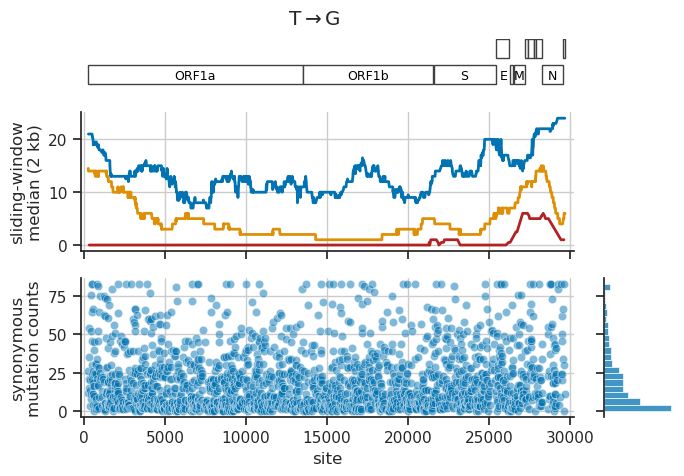

In [7]:
mut_types = sorted(list(counts_df['mut_type'].unique()))
counts_var = 'truncated_actual_count'
print('counts_var', counts_var)
window_flank_size = 1000
print('window size', window_flank_size*2+1)
plot_poisson = False
rolling_dfs = []
means_dict = defaultdict(list)
window_stats_dict = defaultdict(list)
for (mut_type, mut_type_data) in counts_df.groupby('mut_type'):

    print(mut_type)

    # Plot data for syn, nonsyn, stop muts
    (fig, axs) = plt.subplots(
        nrows=3, ncols=2, figsize=[7, 5], sharex='col', sharey='row',
        height_ratios=[1,3,3], width_ratios=[7,1]
    )
    axs = axs.reshape(-1)
    max_window_median = 0
    for (i, (mut_class, data)) in enumerate(mut_type_data.groupby('mut_class')):

        if mut_class in ['noncoding']:
            continue

        # Compute sliding-window medians
        assert len(data['site']) == len(set(data['site']))
        window_dict = defaultdict(list)
        for site in data['site']:
            data_i = data[data['site'].between(site-window_flank_size, site+window_flank_size)]
            window_dict['site'].append(site)
            if len(data_i) == 0:
                window_dict[counts_var].append(np.nan)
            else:
                window_dict[counts_var].append(data_i[counts_var].median())
        rolling_data = pd.DataFrame(window_dict)
        rolling_data['mut_type'] = mut_type
        rolling_data['mut_class'] = mut_class
        rolling_dfs.append(rolling_data)
        if rolling_data[counts_var].max() > max_window_median:
            max_window_median = rolling_data[counts_var].max()
        
        # Plot sliding-window medians and scatter plot
        sns.lineplot(
            x='site', y=counts_var, data=rolling_data, ax=axs[2],
            color=mut_class_colors[mut_class], lw=2
        )
        if mut_class == 'stop':
            zorder = 10
            alpha = 1
        else:
            zorder = 1
            alpha = 0.5
        if mut_class in ['synonymous']:
            sns.scatterplot(
                x='site', y=counts_var, data=data, ax=axs[4],
                alpha=alpha, color=mut_class_colors[mut_class],
                zorder=zorder
            )

    # Plot vertical lines at indicated sites
    coords = []
    if mut_type in ['AT', 'CG', 'GC']:
        coords += [21555]
    elif mut_type in ['CT']:
        coords += [13483]
    for coord in coords:
        for i in [2, 4]:
            axs[i].axvline(coord, ls='--', c='0.25')

    axs[4].set(ylabel='synonymous\nmutation counts')
    axs[2].set(
        ylabel='sliding-window\nmedian (2 kb)',
    )
    axs[2].grid()
    sns.despine()

    # Add gene annotation plot
    for (i, row) in gene_boundaries_df.iterrows():
        start = row['min_site']
        end = row['max_site']
        gene = row['gene']
        if gene in ['ORF1ab']:
            continue
        elif gene in ['ORF1a', 'ORF1b', 'S', 'E', 'M', 'N']:
            y_min = -0.5
            annotate = True
        else:
            y_min = 0.5
            annotate = False
        rectangle = matplotlib.patches.Rectangle((start, y_min), end-start, 0.75, edgecolor='0.25', facecolor='white')
        axs[0].add_patch(rectangle)
        if annotate:
            rx, ry = rectangle.get_xy()
            cx = rx + rectangle.get_width()/2.0
            cy = ry - 0.05 + rectangle.get_height()/2.0
            if gene in ['E']:
                cx -= 450
            axs[0].annotate(
                gene, (cx, cy), color='black', ha='center', va='center',
                fontsize=9
            )
    axs[0].set(ylim=[-0.55,1.25], yticks=[])
    sns.despine(left=True, bottom=True, ax=axs[0])
    axs[0].xaxis.set_tick_params(which='both', bottom=False, labelbottom=False, labeltop=False)

    # Plot the histogram of counts
    data = mut_type_data[mut_type_data['mut_class'] == 'synonymous'].copy()
    nbins = 20
    min_count = data[counts_var].min()
    max_count = data[counts_var].max()
    bin_size = (max_count-min_count)/nbins
    bins = np.arange(min_count, max_count+bin_size, bin_size)
    sns.histplot(
        y=counts_var, data=data, bins=bins, ax=axs[5],
        color=mut_class_colors['synonymous'],
    )

    # Plot histogram of poisson distribution with same mean
    if plot_poisson:
        mean = data[counts_var].mean()
        xs = np.arange(0, data[counts_var].max()+1, 1)
        poisson = scipy.stats.poisson(mean)
        ys = poisson.pmf(xs) * len(data)
        sim_counts = poisson.rvs(size=len(data), random_state=1)
        sns.histplot(y=sim_counts, bins=bins, color='0.5', ax=axs[5])
        axs[5].axhline(mean, ls='--', c='0.25')
    sns.despine(bottom=True, ax=axs[5])
    axs[5].set(xlabel='', xticks=[])

    axs[1].axis('off')
    axs[3].axis('off')
    axs[0].set(xlim=[-200,30200])
    axs[4].grid()

    plt.suptitle(mut_type[0]+r'$\rightarrow$'+mut_type[1], x=0.46, y=0.95)
    plt.tight_layout(w_pad=0)
    plt.show()

rolling_df = pd.concat(rolling_dfs)

Plot simplified versions of the above plots for just synonymous mutations

counts_var truncated_actual_count
window size 2001
AG


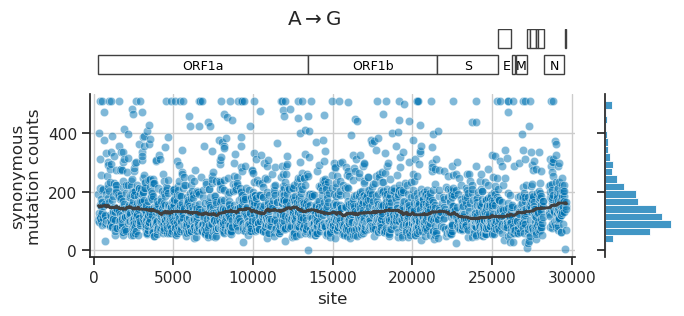

AT


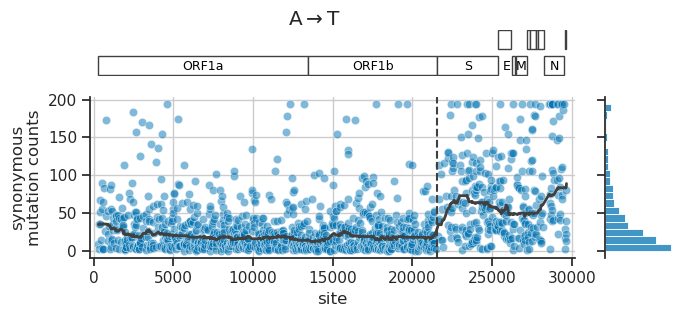

CT


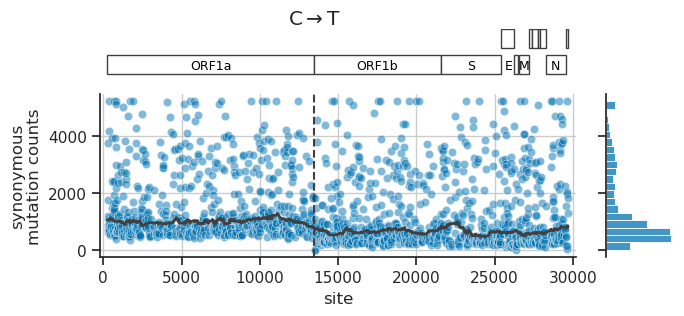

In [8]:
mut_types = ['AG', 'AT', 'CT']
counts_var = 'truncated_actual_count'
print('counts_var', counts_var)
window_flank_size = 1000
print('window size', window_flank_size*2+1)

for mut_type in mut_types:

    # Get data
    print(mut_type)
    data = counts_df[
        (counts_df['mut_type'] == mut_type) &
        (counts_df['mut_class'] == 'synonymous')
    ].copy()
    rolling_data = rolling_df[
        (rolling_df['mut_type'] == mut_type) &
        (rolling_df['mut_class'] == 'synonymous')
    ]

    # Plot data
    (fig, axs) = plt.subplots(
        nrows=2, ncols=2, figsize=[7, 3.5], sharex='col', sharey='row',
        height_ratios=[1,3.5], width_ratios=[7,1]
    )
    axs = axs.reshape(-1)
    
    # Plot sliding-window medians and scatter plot
    sns.lineplot(
        x='site', y=counts_var, data=rolling_data, ax=axs[2],
        color='0.25', lw=2
    )
    sns.scatterplot(
        x='site', y=counts_var, data=data, ax=axs[2],
        alpha=0.5, color=mut_class_colors['synonymous'],
        zorder=1
    )

    # Plot vertical lines at indicated sites
    coords = []
    if mut_type in ['AT', 'CG', 'GC']:
        coords += [21555]
    elif mut_type in ['CT']:
        coords += [13483]
    for coord in coords:
        axs[2].axvline(coord, ls='--', c='0.25')

    axs[2].set(ylabel='synonymous\nmutation counts')
    axs[2].grid()
    sns.despine()

    # Add gene annotation plot
    for (i, row) in gene_boundaries_df.iterrows():
        start = row['min_site']
        end = row['max_site']
        gene = row['gene']
        if gene in ['ORF1ab']:
            continue
        elif gene in ['ORF1a', 'ORF1b', 'S', 'E', 'M', 'N']:
            y_min = -0.5
            annotate = True
        else:
            y_min = 0.5
            annotate = False
        rectangle = matplotlib.patches.Rectangle((start, y_min), end-start, 0.75, edgecolor='0.25', facecolor='white')
        axs[0].add_patch(rectangle)
        if annotate:
            rx, ry = rectangle.get_xy()
            cx = rx + rectangle.get_width()/2.0
            cy = ry - 0.05 + rectangle.get_height()/2.0
            if gene in ['E']:
                cx -= 450
            axs[0].annotate(
                gene, (cx, cy), color='black', ha='center', va='center',
                fontsize=9
            )
    axs[0].set(ylim=[-0.55,1.25], yticks=[])
    sns.despine(left=True, bottom=True, ax=axs[0])
    axs[0].xaxis.set_tick_params(which='both', bottom=False, labelbottom=False, labeltop=False)

    # Plot the histogram of counts
    nbins = 20
    min_count = data[counts_var].min()
    max_count = data[counts_var].max()
    bin_size = (max_count-min_count)/nbins
    bins = np.arange(min_count, max_count+bin_size, bin_size)
    sns.histplot(
        y=counts_var, data=data, bins=bins, ax=axs[3],
        color=mut_class_colors['synonymous'],
    )
    sns.despine(bottom=True, ax=axs[3])
    axs[3].set(xlabel='', xticks=[])

    axs[1].axis('off')
    axs[0].set(xlim=[-200,30200])

    plt.suptitle(mut_type[0]+r'$\rightarrow$'+mut_type[1], x=0.46, y=0.9)
    plt.tight_layout(w_pad=0)
    plt.show()

Make a summary plot showing the sliding-window medians of synonymous mutations for each mutation type

truncated_actual_count


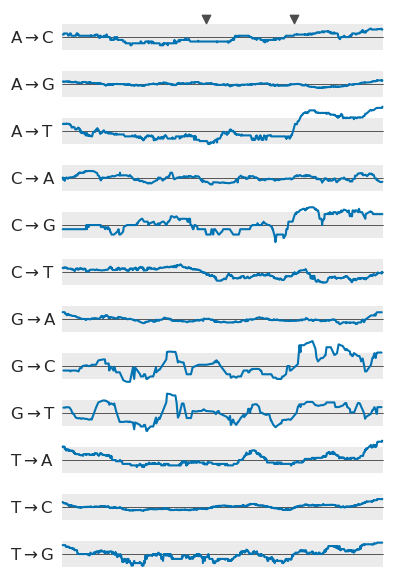

In [10]:
# Get the median of each mutation type across all sites
#counts_var = 'truncated_actual_count'
print(counts_var)
median_data = counts_df[counts_df['mut_class'] == 'synonymous'].groupby('mut_type', as_index=False).agg(
    median = (counts_var, 'median')
)

# Get window data for synonymous mutations and then merge with the dataframe
# giving global averages
data = rolling_df[rolling_df['mut_class'] == 'synonymous'].copy()
data.rename(columns={
    counts_var : 'observed data',
}, inplace=True)
data = data.melt(
    id_vars=['site', 'mut_type'], value_vars=['observed data'],
    value_name='counts', var_name='count_type'
).merge(median_data[['mut_type', 'median']], on='mut_type', how='left')
data['fold_change_from_median'] = data['counts'] / data['median']

var_data = data.groupby('mut_type', as_index=False).agg(
    var = ('fold_change_from_median', 'var')
)
data = data.merge(var_data, on='mut_type')
data.sort_values('var', ascending=False, inplace=True)

data['mut_type_arrow'] = data['mut_type'].apply(
    lambda x: x[0]+r'$\rightarrow$'+x[1]
)

data = data[data['count_type'] == 'observed data']

# Plot data
min_site = data['site'].min() - 100
max_site = data['site'].max() + 100
(fig, axs) = plt.subplots(nrows=12, sharex=True, sharey=True, figsize=[4,6])
axs[0].scatter([13483, 21555], [2.6, 2.6], c='0.3', marker='v')
for (i, (mut_type, mut_type_data)) in enumerate(data.groupby('mut_type_arrow')):
    sns.lineplot(
        x='site', y='fold_change_from_median', data=mut_type_data,
        ax=axs[i], color=mut_class_colors['synonymous']
    )
    rect = patches.Rectangle(
        (min_site, 0.5), max_site - min_site, 1.5,
        linewidth=0, color='0.92', zorder=0
    )
    axs[i].add_patch(rect)
    axs[i].plot([min_site, max_site], [1, 1], c='k', lw=0.5, zorder=0)
    axs[i].set_yscale('log', base=2)
    axs[i].set(ylabel='', yticks=[], xticks=[]) # 0.5, 1, 4
    axs[i].set_title(mut_type, loc='left', y=0.11, x=-0.1)
    sns.despine(bottom=True, left=True, ax=axs[i])

plt.tight_layout(h_pad=0)
plt.show()

Plot distribution of counts for paired vs. unpaired bases

ss_prediction truncated_actual_count


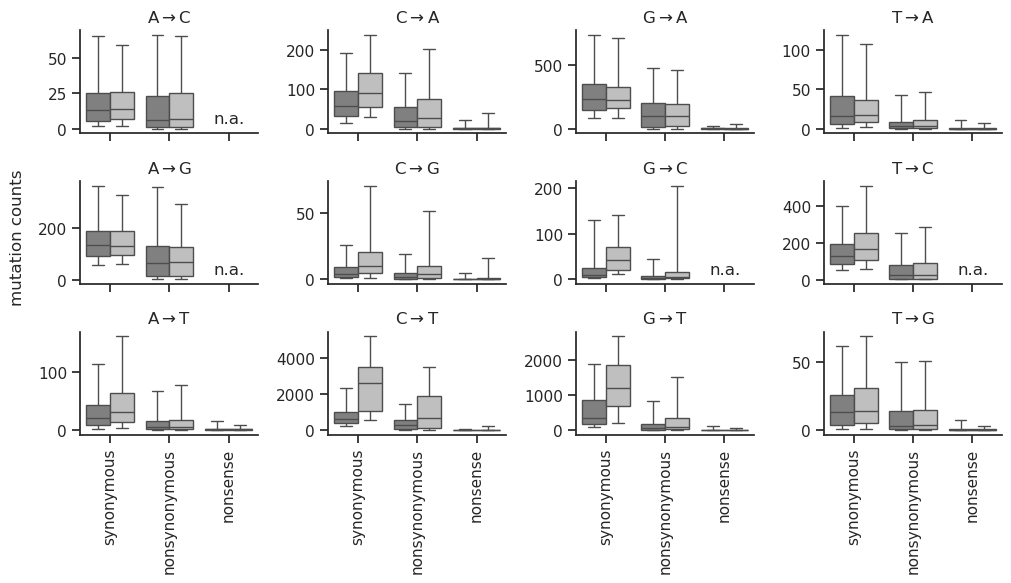

In [11]:
classification_var = 'ss_prediction' # 'biphasic_at' # 
counts_var = 'truncated_actual_count'
print(classification_var, counts_var)
if classification_var == 'ss_prediction':
    hue_order = ['paired', 'unpaired']
elif classification_var == 'biphasic_at':
    hue_order = ['phase_1', 'phase_2']
else:
    raise ValueError()
(fig, axs) = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=False, figsize=[10,6])
axs = axs.reshape(-1, order='F')
order = ['synonymous', 'nonsynonymous', 'nonsense']
for i, (mut_type, mut_data) in enumerate(counts_df.groupby('mut_type_arrow')):
    sns.boxplot(
        x='mut_class', y=counts_var, data=mut_data,
        hue=classification_var, hue_order=hue_order, palette=['0.5', '0.75'],
        whis=(5,95), showfliers=False, ax=axs[i], order=order
    )
    if sum(mut_data['mut_class'] == 'nonsense') == 0:
        axs[i].annotate('n.a.', (0.75, 0.1), xycoords=axs[i].transAxes)
    axs[i].set(title=mut_type, xlabel='', ylabel='')
    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].get_legend().remove()

fig.text(-0.01, 0.59, 'mutation counts', va='center', rotation='vertical')
plt.tight_layout()
sns.despine()
plt.show()

For each mutation type, plot the difference in median synonymous counts for paired vs. unpaired

mut_type fold_diff p_val
AC 1.077 0.5
AG 0.992 0.6
AT 1.55 0.0
CA 1.561 0.0
CG 2.5 0.0
CT 4.229 0.0
GA 0.974 0.5
GC 4.611 0.0
GT 3.506 0.0
TA 1.062 0.4
TC 1.291 0.0
TG 1.077 0.2


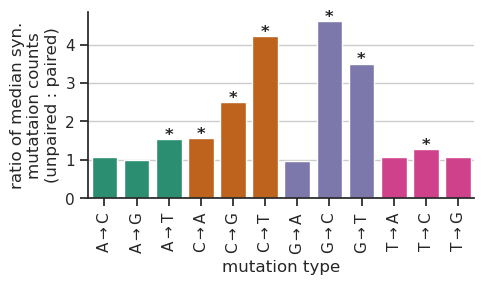

In [12]:
# Compute fold change in median counts between unpaired vs. paired sites or sites before
# or after the biphasic change at site 21,555
classification_var = 'ss_paired' # 'nt_site_before_21555' # 
counts_var = 'truncated_actual_count'
ratio_label_dict = {
    'ss_paired' : '(unpaired : paired)',
    'nt_site_before_21555' : '(post- : pre- site 21,555)'
}
data = (
    counts_df[counts_df['mut_class'] == 'synonymous']
    .groupby(['mut_type', classification_var])[[counts_var]].median()
    .reset_index()
    .pivot_table(index='mut_type', columns=classification_var, values=counts_var)
    .reset_index()
)

data['fold_diff'] = data[False] / data[True]
data['wt_nt'] = data['mut_type'].apply(lambda x: x[0])
data['mut_type_arrow'] = data['mut_type'].apply(
    lambda x: x[0]+r'$\rightarrow$'+x[1]
)
fold_change_data = data.copy()

# Plot data
mut_type_order = [
    'AC', 'AG', 'AT',
    'CA', 'CG', 'CT',
    'GA', 'GC', 'GT',
    'TA', 'TC', 'TG'
]
mut_type_arrow_order = [x[0]+r'$\rightarrow$'+x[1] for x in mut_type_order]
plt.figure(figsize=[5,3])
sns.barplot(
    x='mut_type_arrow', y='fold_diff', data=fold_change_data,
    hue='wt_nt', dodge=False, palette=mut_type_pal
)

# Use randomization to test the null hypothesis that the medians are >1 due
# to random chance
dfs = []
rs = np.random.RandomState(seed=1)
for i in range(10):
    
    # Get data for synonymous mutations
    data = counts_df[counts_df['mut_class'] == 'synonymous'].copy()
    
    # Get data for each mutation type, shuffle counts between sites, and then
    # concatenate the data across mutation teyps
    shuffled_dfs = []
    for (mut_type, data_i) in data.groupby('mut_type'):
        data_i['shuffled_counts'] = list(data_i[counts_var].sample(frac=1, random_state=rs))
        shuffled_dfs.append(data_i)
    data = pd.concat(shuffled_dfs)

    # Compute the fold difference between medians using shuffled counts
    data = (
        data
        .groupby(['mut_type', classification_var])[['shuffled_counts']].median()
        .reset_index()
        .pivot_table(index='mut_type', columns=classification_var, values='shuffled_counts')
        .reset_index()
    )
    data['fold_diff'] = data[False] / data[True]
    data['rand_trial'] = i
    dfs.append(data)

data = pd.concat(dfs)
rand_data = data.pivot(index='rand_trial', columns='mut_type', values='fold_diff')

# Compute p values from randomized data and add asterisk to plot if
# a mutation type's corrected p value is < 0.05
print('mut_type', 'fold_diff', 'p_val')
for (i, row) in fold_change_data.iterrows():
    mut_type = row['mut_type']
    frac_rand_greater = sum(rand_data[mut_type] >= row['fold_diff']) / len(rand_data)
    print(mut_type, round(row['fold_diff'], 3), round(frac_rand_greater, 3))
    if frac_rand_greater * 12 < 0.05:
        y = row['fold_diff'] + 0.1
        plt.annotate('*', (i,y), weight='bold', va='center', ha='center')

plt.tick_params('x', labelrotation=90)
ax = plt.gca()
ax.set(
    xlabel='mutation type',
    ylabel=f'ratio of median syn.\nmutataion counts\n{ratio_label_dict[classification_var]}'
)
ax.grid(axis='y')
ax.get_legend().remove()
plt.tight_layout()
sns.despine()
plt.show()

Plot a sliding-window average of the fraction of nucleotides that are paired in the genome's predicted secondary structure.

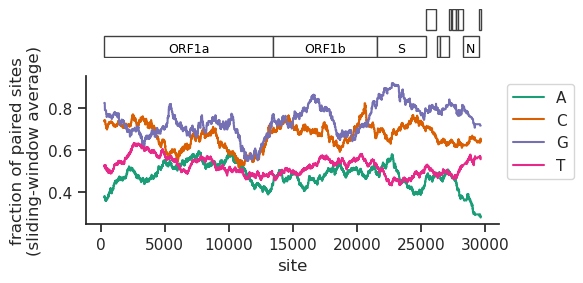

In [13]:
# Compute average ss content over sliding window
window_dict = defaultdict(list)
window_flank_size = 1000
data = counts_df[
    counts_df['mut_class'] == 'synonymous'
].drop_duplicates(subset='site')
dfs = []
for site in data['site']:
    data_i = data[data['site'].between(site-window_flank_size, site+window_flank_size)]
    data_i = (
        data_i
        .groupby('wt_nt', as_index=False)[['ss_prediction']]
        .value_counts()
        .pivot(index='wt_nt', columns='ss_prediction', values='count')
        .reset_index()
    )
    data_i['site'] = site
    data_i['frac_ss'] = data_i['paired'] / (data_i['paired'] + data_i['unpaired'])
    dfs.append(data_i)
ss_window_df = pd.concat(dfs)
ss_window_df

# Plot sliding-window average
(fig, axs) = plt.subplots(
    nrows=2, figsize=[6, 3], sharex=True,
    height_ratios=[1,3]
)
sns.lineplot(
    x='site', y='frac_ss', data=ss_window_df,
    hue='wt_nt', palette=mut_type_pal, ax=axs[1]
)
axs[1].legend(bbox_to_anchor=(1,1))
axs[1].set(ylabel='fraction of paired sites\n(sliding-window average)')

# Add gene annotation plot
for (i, row) in gene_boundaries_df.iterrows():
    start = row['min_site']
    end = row['max_site']
    gene = row['gene']
    if gene in ['ORF1ab']:
        continue
    elif gene in ['ORF1a', 'ORF1b', 'S', 'E', 'M', 'N']:
        y_min = -0.5
        annotate = True
    else:
        y_min = 0.5
        annotate = False
    rectangle = matplotlib.patches.Rectangle((start, y_min), end-start, 0.75, edgecolor='0.25', facecolor='white')
    axs[0].add_patch(rectangle)
    if annotate:
        rx, ry = rectangle.get_xy()
        cx = rx + rectangle.get_width()/2.0
        cy = ry - 0.05 + rectangle.get_height()/2.0
        if gene in ['E', 'M']:
            cy -= 0.7
        axs[0].annotate(
            gene, (cx, cy), color='black', ha='center', va='center',
            fontsize=9
        )

sns.despine()
axs[0].set(ylim=[-0.55,1.25], yticks=[])
sns.despine(left=True, bottom=True, ax=axs[0])
axs[0].xaxis.set_tick_params(which='both', bottom=False, labelbottom=False, labeltop=False)

plt.tight_layout()
plt.show()

## Examine the relationship between counts and local sequence context

First, for each mutation type, group sites by 3-mer motifs and compute median counts per motif, only doing so for motifs with at least 10 sites with data for that mutation type.

In [14]:
# Compute global medians
counts_var = 'truncated_actual_count'
global_medians = (
    counts_df[counts_df['mut_class'] == 'synonymous']
    .groupby(['mut_type'], as_index=False)
    .agg(global_median_counts=pd.NamedAgg(column=counts_var, aggfunc='median'))
)

# Compute motif medians for motifs with at least 10 sites, then merge with
# data on global medians
motif_medians = (
    counts_df[counts_df['mut_class'] == 'synonymous']
    .groupby(['mut_type', 'motif'], as_index=False)
    .agg(
        median_counts=pd.NamedAgg(column=counts_var, aggfunc='median'),
        median_counts_pre_omicron=pd.NamedAgg(column='truncated_actual_count_pre_omicron', aggfunc='median'),
        median_counts_omicron=pd.NamedAgg(column='truncated_actual_count_omicron', aggfunc='median'),
        n=pd.NamedAgg(column='motif', aggfunc='count'),
    )
    .query('n >= 10')
    .merge(global_medians, on='mut_type')
)
motif_medians['fold_change_from_global'] = motif_medians['median_counts'] / motif_medians['global_median_counts']

# Add a column giving a reference motif that the motif for mutation types
# away from T or C, but the reverse-complement motif for mutation types
# away from A or G, allowing for comparison of reverse-complement mutation
# types
def get_ref_motif(mut_type, motif):
    if mut_type[0] in ['A', 'G']:
        return str(Seq(motif).reverse_complement())
    else:
        return motif
motif_medians['ref_motif'] = motif_medians.apply(
    lambda row: get_ref_motif(row['mut_type'], row['motif']), axis=1
)

motif_medians['mut_type_arrow'] = motif_medians['mut_type'].apply(
    lambda x: x[0]+r'$\rightarrow$'+x[1]
)

Next, for each mutation type, plot the distribution of mutation counts as a function of a site's 3-mer motif.

TG
global median 13.0
min median 1
max median 60
max/min median 60.5


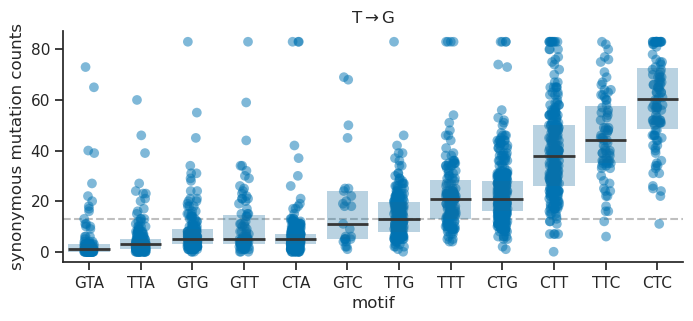

AC
global median 14.0
min median 4
max median 68
max/min median 16.88


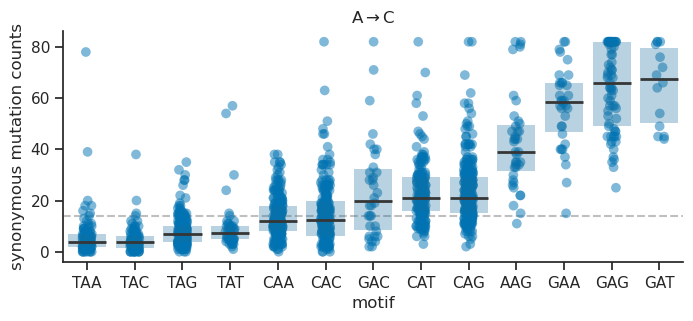

TA
global median 16.0
min median 2
max median 55
max/min median 27.5


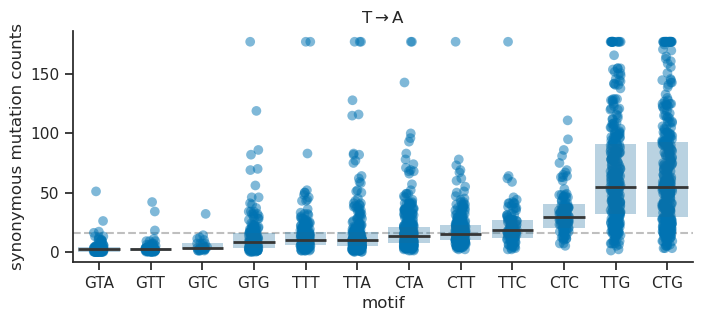

AT
global median 24.0
min median 3
max median 53
max/min median 17.67


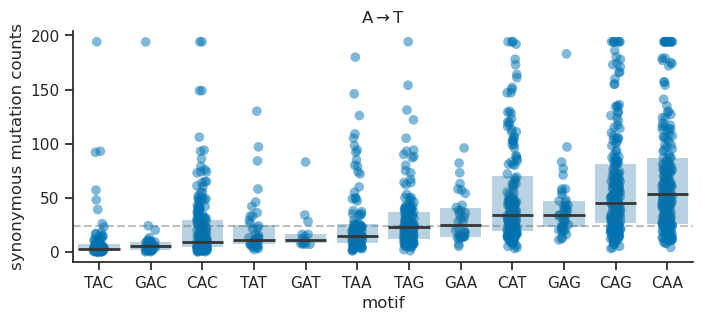

TC
global median 142.5
min median 86
max median 472
max/min median 5.49


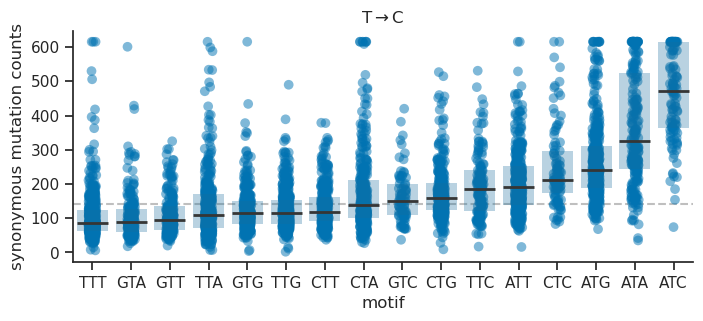

AG
global median 132.0
min median 85
max median 348
max/min median 4.09


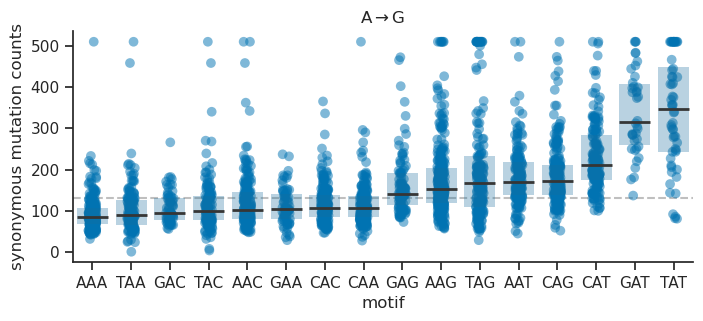

CT
global median 840.0
min median 540
max median 1801
max/min median 3.34


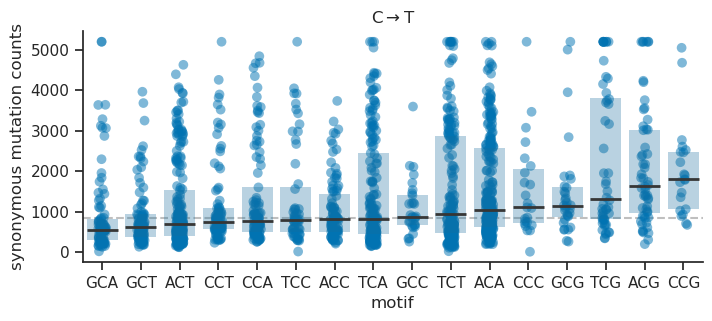

GA
global median 229.0
min median 113
max median 803
max/min median 7.11


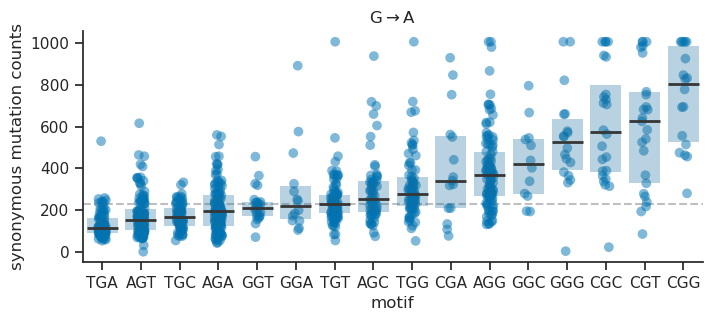

CA
global median 66.0
min median 31
max median 154
max/min median 4.97


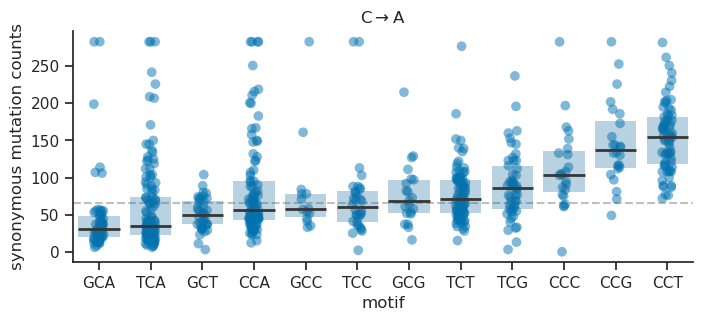

GT
global median 433.0
min median 331
max median 809
max/min median 2.44


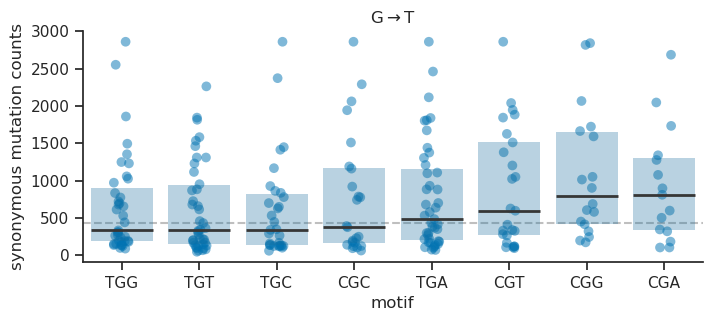

CG
global median 5.0
min median 3
max median 10
max/min median 3.33


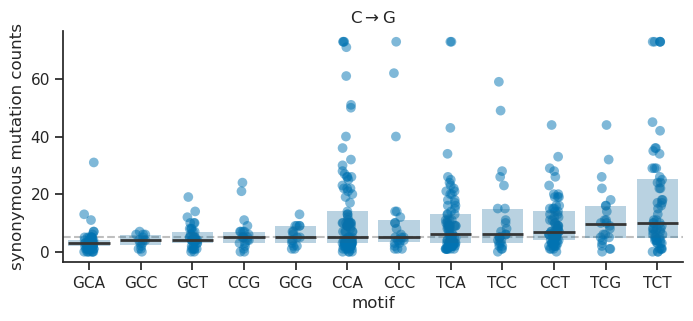

GC
global median 14.0
min median 9
max median 54
max/min median 6.0


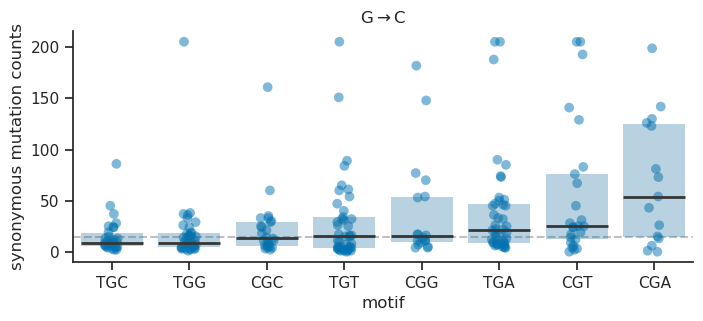

In [15]:
counts_var = 'truncated_actual_count'
mut_classes = [
    'synonymous',
    # 'nonsynonymous',
    # 'stop'
]
mut_types = [
    'TG', 'AC',
    'TA', 'AT', 
    'TC', 'AG',
    'CT', 'GA',
    'CA', 'GT',
    'CG', 'GC',
]
for mut_type in mut_types:

    # Get data for mutation type
    print(mut_type)
    data = counts_df[
        (counts_df['mut_class'].isin(mut_classes)) &
        (counts_df['mut_type'] == mut_type)
    ].copy()
    global_median = data[data['mut_class'] == 'synonymous'][counts_var].median()
    motif_medians_data = motif_medians[motif_medians['mut_type'] == mut_type]

    # Report stats
    print('global median', global_median)
    print('min median', round(motif_medians_data['median_counts'].min()))
    print('max median', round(motif_medians_data['median_counts'].max()))
    print('max/min median', round(motif_medians_data['median_counts'].max()/motif_medians_data['median_counts'].min(), 2))

    # Sort motifs by their meian, then plot the distribution of counts for each motif
    data = data.merge(motif_medians_data, on=['mut_type', 'motif'], how='right')
    data.sort_values('median_counts', inplace=True)
    if len(mut_classes) == 1:
        plt.figure(figsize=[8,3])
    else:
        plt.figure(figsize=[12,3])
    sns.boxplot(
        x='motif', y=counts_var, data=data,
        hue='mut_class', hue_order=mut_classes, palette=mut_class_colors,
        #showmeans=True,
        showfliers=False, whis=0,
        linewidth=0,
        medianprops={"linewidth": 2},
        boxprops={'alpha':.3},
        zorder=10,
    )
    sns.stripplot(
        x='motif', y=counts_var, data=data,
        hue='mut_class', hue_order=mut_classes, palette=mut_class_colors,
        dodge=True, alpha=0.5, s=7
    )
    plt.axhline(global_median, c='0.75', ls='--')
    plt.legend().remove()
    sns.despine()
    plt.title(mut_type[0]+r'$\rightarrow$'+mut_type[1])
    plt.ylabel('synonymous mutation counts')
    plt.show()

Plot counts per motif for a specific mutation type and subset of sites

CT
global median 620.5
min median 510
max median 1727
max/min median 3.39


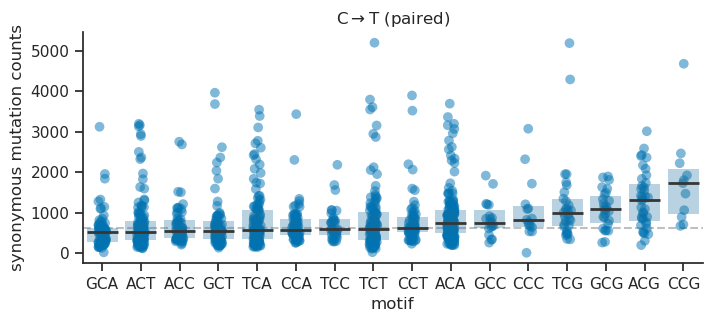

In [16]:
mut_type = 'CT'
title_suffix = '(paired)'
data = counts_df[
    (counts_df['mut_class'].isin(mut_classes)) &
    (counts_df['ss_prediction'] == 'paired') &
    (counts_df['mut_type'] == mut_type)
].copy()

# Compute the mean counts of syn mutations for each motif
print(mut_type)
global_median = data[data['mut_class'] == 'synonymous'][counts_var].median()
medians_df = (
    data[data['mut_class'] == 'synonymous']
    .groupby(['mut_type', 'motif'], as_index=False)
    .agg(
        median_counts=pd.NamedAgg(column=counts_var, aggfunc='median'),
        n=pd.NamedAgg(column='motif', aggfunc='count'),
    )
    .query('n >= 10')
    .merge(global_medians, on='mut_type')
)

# Report stats
print('global median', global_median)
print('min median', round(medians_df['median_counts'].min()))
print('max median', round(medians_df['median_counts'].max()))
print('max/min median', round(medians_df['median_counts'].max()/medians_df['median_counts'].min(), 2))

# Sort motifs by their mean, then plot the distribution of counts for each motif
data = data.merge(medians_df, on=['mut_type', 'motif'])
data.sort_values('median_counts', inplace=True)

if len(mut_classes) == 1:
    plt.figure(figsize=[8,3])
else:
    plt.figure(figsize=[12,3])
sns.boxplot(
    x='motif', y=counts_var, data=data,
    hue='mut_class', hue_order=mut_classes, palette=mut_class_colors,
    #showmeans=True,
    showfliers=False, whis=0,
    linewidth=0,
    medianprops={"linewidth": 2},
    boxprops={'alpha':.3},
    zorder=10,
)
sns.stripplot(
    x='motif', y=counts_var, data=data,
    hue='mut_class', hue_order=mut_classes, palette=mut_class_colors,
    dodge=True, alpha=0.5, s=7
)
plt.axhline(global_median, c='0.75', ls='--')
plt.legend().remove()
sns.despine()
plt.title(mut_type[0]+r'$\rightarrow$'+mut_type[1]+f' {title_suffix}')
plt.ylabel('synonymous mutation counts')
plt.show()

Plot the correlation in medians between reverse-complement motifs and mutation types.

['TG', 'AC']
r = 0.979
m = 0.889 b = -1.552


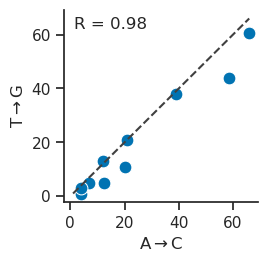

['TA', 'AT']
r = 0.967
m = 1.138 b = -5.421


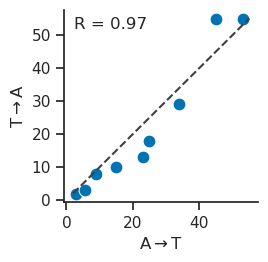

['TC', 'AG']
r = 0.881
m = 1.144 b = -1.406


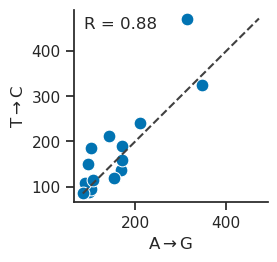

['CT', 'GA']
r = 0.83
m = 1.487 b = 468.29


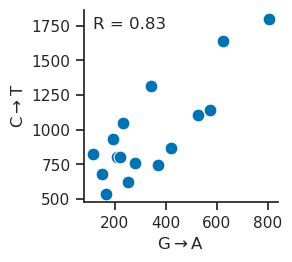

['CA', 'GT']
r = 0.781
m = 0.139 b = -3.504


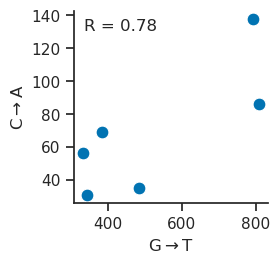

['CG', 'GC']
r = 0.949
m = 0.119 b = 3.164


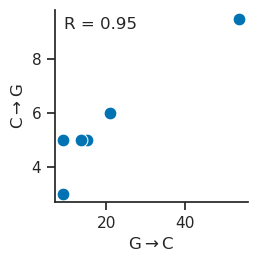

In [17]:
mut_type_pairs = [
    ['TG', 'AC'],
    ['TA', 'AT'],
    ['TC', 'AG'],
    ['CT', 'GA'],
    ['CA', 'GT'],
    ['CG', 'GC'],
]
mirror_metadata = {}
for mut_type_pair in mut_type_pairs:
    data = (
        motif_medians[motif_medians['mut_type'].isin(mut_type_pair)]
        .pivot(index='ref_motif', columns='mut_type', values='median_counts')
        .dropna()
    )
    plt.figure(figsize=[2.5, 2.5])
    x = mut_type_pair[1]
    y = mut_type_pair[0]
    sns.scatterplot(x=x, y=y, data=data, s=85, alpha=1.0)
    r = data[x].corr(data[y])
    (m, b) = np.polyfit(data[x], data[y], 1)
    plt.annotate(f'R = {round(r, 2)}', [0.05, 0.9], xycoords='axes fraction')
    mirror_metadata[mut_type_pair[0]] = [round(r, 4), round(m, 2)]
    print(mut_type_pair)
    print('r =', round(r, 3),)
    print('m =', round(m, 3), 'b =', round(b, 3))
    min_val = data.min().min()
    max_val = data.max().max()
    if mut_type_pair[0][0] == 'T':
        plt.plot([min_val, max_val], [min_val, max_val], ls='--', c='0.25')
    plt.xlabel(mut_type_pair[1][0]+r'$\rightarrow$'+mut_type_pair[1][1])
    plt.ylabel(mut_type_pair[0][0]+r'$\rightarrow$'+mut_type_pair[0][1])
    sns.despine()
    plt.show()

Plot the distribution of motif medians relative to the global median

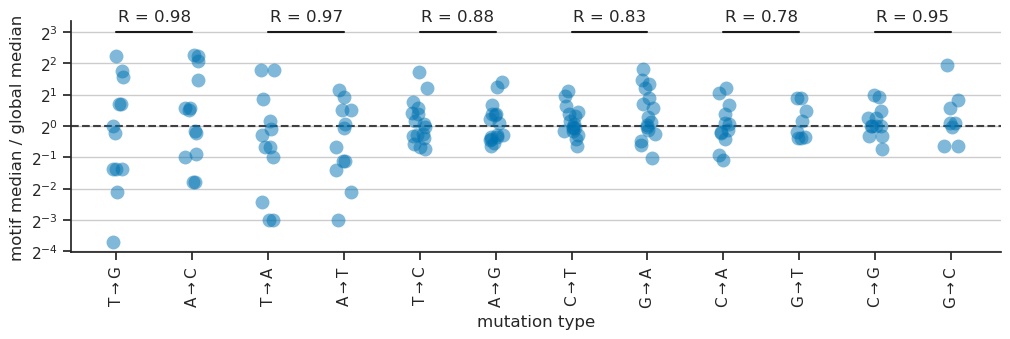

In [18]:
# Sort the input data by pairs of mutation types
mut_types_order = []
for mut_type_pair in mut_type_pairs:
    mut_types_order += mut_type_pair
mut_type_indices = {mut_type : i for (i, mut_type) in enumerate(mut_types_order)}
motif_medians['mut_type_index'] = motif_medians['mut_type'].apply(lambda x: mut_type_indices[x])
motif_medians.sort_values('mut_type_index', inplace=True)

# Plot data
plt.figure(figsize=[12,3])
sns.stripplot(x='mut_type_arrow', y='fold_change_from_global', data=motif_medians, s=10, alpha=0.5)
plt.axhline(1, ls='--', c='0.25')

for (i, mut_type) in enumerate(mut_types_order):
    if mut_type in mirror_metadata:
        (r, m) = mirror_metadata[mut_type]
        #r = round(r, 2)
        r = f'R = {round(r, 2)}'
        # if p < 0.001:
        #     p = 'p < 0.001'
        # else:
        #     p = f'p = {round(p, 3)}'
        plt.plot([i,i+1], [8,8], c='k')
        plt.annotate(f'{r}', [i+0.5, 9.5], ha='center', va='bottom')

plt.tick_params('x', labelrotation=90)
plt.xlabel('mutation type')
plt.ylabel('motif median / global median')
ax = plt.gca()
ax.set_yscale('log', base=2)
plt.yticks([1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8])
plt.grid(axis='y')
plt.minorticks_off()
sns.despine()
plt.show()

Analyze how much 3-mer motif medians differ between paired vs. unpaired sites

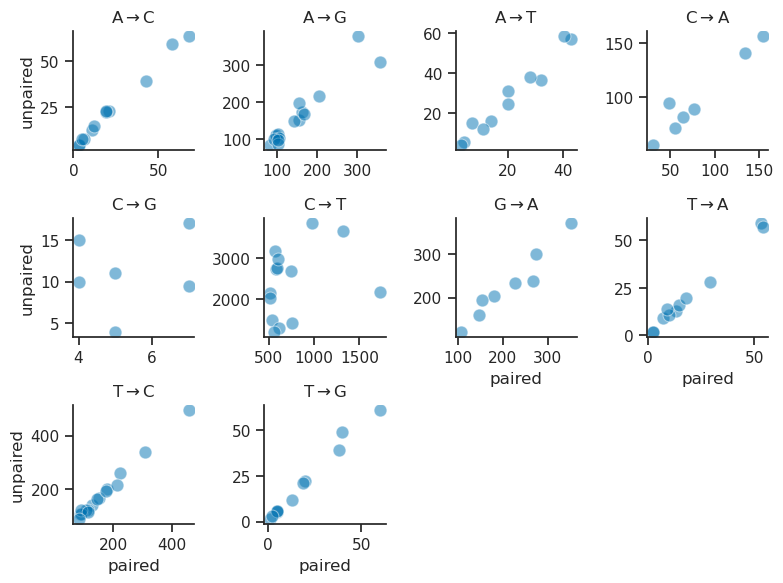

In [19]:
# Get data
counts_var = 'truncated_actual_count'
data = (
    counts_df[counts_df['mut_class'] == 'synonymous']
    .groupby(['mut_type_arrow', 'motif', 'ss_prediction'], as_index=False)
    .agg(
        mean_counts=pd.NamedAgg(column=counts_var, aggfunc='median'),
        n=pd.NamedAgg(column='motif', aggfunc='count'),
    )
    .query('n >= 10')
    .pivot_table(index=['mut_type_arrow', 'motif'], columns='ss_prediction', values='mean_counts')
    .reset_index()
    .dropna()
)

# Plot data
nobs = data['mut_type_arrow'].value_counts()
mut_types_to_plot = list(nobs[nobs > 1].index.values)
data = data[data['mut_type_arrow'].isin(mut_types_to_plot)]
g = sns.FacetGrid(data, col='mut_type_arrow',  col_wrap=4, sharex=False, sharey=False, height=2, aspect=1)
g.map(sns.scatterplot, 'paired', 'unpaired', alpha=0.5, s=85)
g.set_titles("{col_name}")
plt.show()

Analyze how much 3-mer motif medians differ between large segments of the genome (capturing trends related to global sequence context).

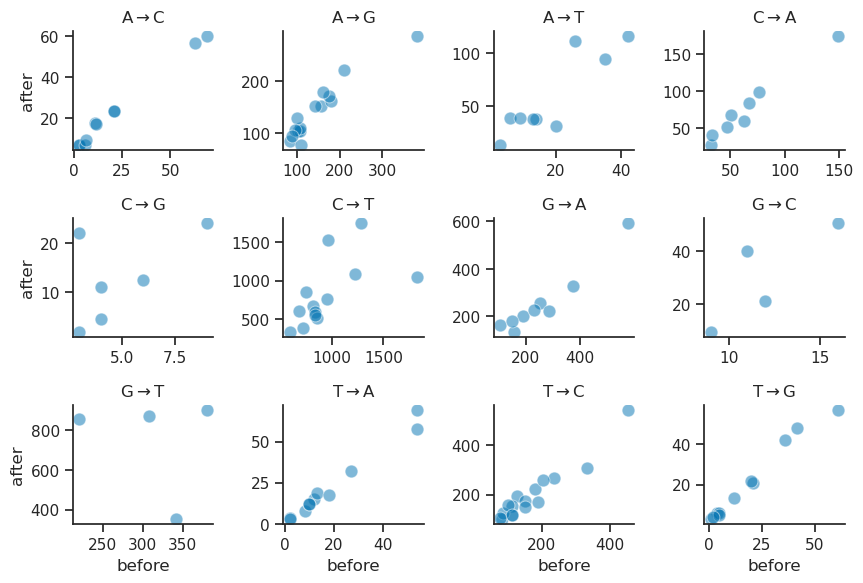

In [20]:
# Get data
counts_var = 'truncated_actual_count'
data = (
    counts_df[counts_df['mut_class'] == 'synonymous']
    .groupby(['mut_type_arrow', 'motif', 'nt_site_before_21555'], as_index=False)
    .agg(
        mean_counts=pd.NamedAgg(column=counts_var, aggfunc='median'),
        n=pd.NamedAgg(column='motif', aggfunc='count'),
    )
    .query('n >= 10')
    .sort_values('mean_counts', ascending=False)
    .pivot_table(index=['mut_type_arrow', 'motif'], columns='nt_site_before_21555', values='mean_counts')
    .reset_index()
    .dropna()
)

# Plot data
nobs = data['mut_type_arrow'].value_counts()
mut_types_to_plot = list(nobs[nobs > 1].index.values)
data = data[data['mut_type_arrow'].isin(mut_types_to_plot)]
data.rename(columns={True : 'before', False : 'after'}, inplace=True)
g = sns.FacetGrid(data, col='mut_type_arrow',  col_wrap=4, sharex=False, sharey=False, height=2, aspect=1.1)
g.map(sns.scatterplot, 'before', 'after', alpha=0.5, s=85)
g.set_titles("{col_name}")
#plt.suptitle('counts before or after nucleotide 21,555 in the genome', y=1.04)
plt.show()

Examine the correlation in 3mer motif patterns between CT and GA.

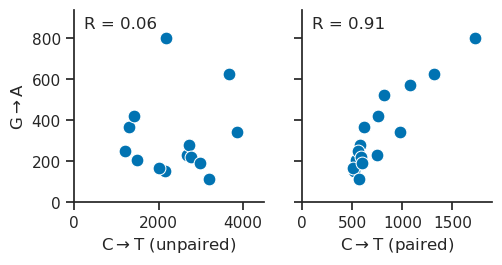

In [21]:
# Get data
ct_paired_data = counts_df[
    (counts_df['mut_class'] == 'synonymous') &
    (counts_df['ss_prediction'].isin(['paired'])) &
    (counts_df['mut_type'] == 'CT')
].copy()
ct_paired_data['mut_type'] = 'CT_paired'

ct_unpaired_data = counts_df[
    (counts_df['mut_class'] == 'synonymous') &
    (counts_df['ss_prediction'].isin(['unpaired'])) &
    (counts_df['mut_type'] == 'CT')
].copy()
ct_unpaired_data['mut_type'] = 'CT_unpaired'

ga_data = counts_df[
    (counts_df['mut_class'] == 'synonymous') &
    (counts_df['ss_prediction'].isin(['unpaired', 'paired'])) &
    (counts_df['mut_type'] == 'GA')
].copy()

data = pd.concat([ct_paired_data, ct_unpaired_data, ga_data])

# Compute the median counts of syn mutations for each motif
medians_df = (
    data[data['mut_class'] == 'synonymous']
    .groupby(['mut_type', 'motif'], as_index=False)
    .agg(
        mean_counts=pd.NamedAgg(column=counts_var, aggfunc='median'),
        n=pd.NamedAgg(column='motif', aggfunc='count'),
    )
    .query('n >= 10')
    .sort_values('mean_counts', ascending=False)
    .dropna()
)
medians_df['ref_motif'] = medians_df.apply(
    lambda row: get_ref_motif(row['mut_type'], row['motif']), axis=1
)

# Plot data
data = (
    medians_df
    .pivot_table(index='ref_motif', columns='mut_type', values='mean_counts')
    #.dropna()
)
(fig, axs) = plt.subplots(ncols=2, sharey=True, figsize=[5.4,2.5])
sns.scatterplot(x='CT_unpaired', y='GA', data=data, alpha=1.0, s=85, ax=axs[0])
sns.scatterplot(x='CT_paired', y='GA', data=data, alpha=1.0, s=85, ax=axs[1])

for (i, x) in enumerate(['CT_unpaired', 'CT_paired']):
    r = data[x].corr(data['GA'])
    axs[i].annotate(f'R = {round(r, 2)}', [0.05, 0.9], xycoords='axes fraction')

axs[0].set(ylabel=r'G$\rightarrow$A', xlabel=r'C$\rightarrow$T (unpaired)', ylim=[0,940] , xlim=[0,4500])
axs[1].set(xlabel=r'C$\rightarrow$T (paired)', xlim=[0,1900])
sns.despine()
plt.show()

Examine correlation between motif medians for counts from pre-Omicron clades vs. Omicron clades

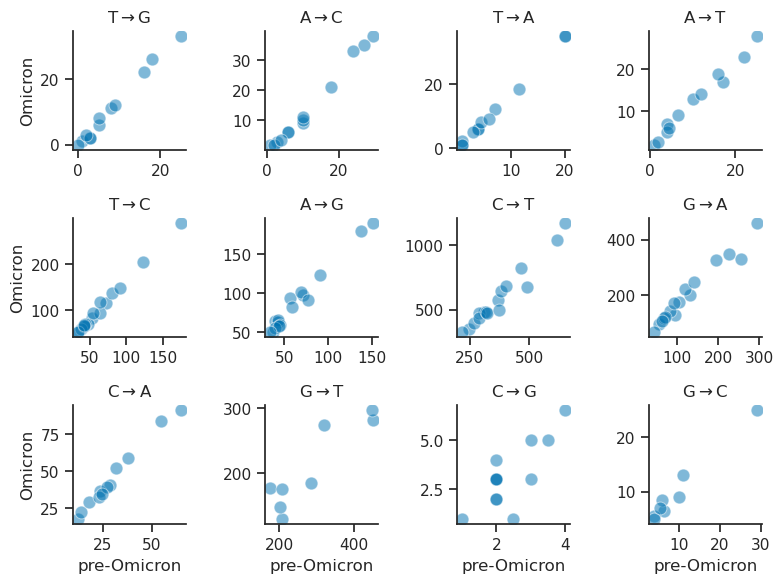

In [22]:
g = sns.FacetGrid(
    motif_medians.rename(columns={'median_counts_pre_omicron':'pre-Omicron', 'median_counts_omicron':'Omicron'}),
    col='mut_type_arrow',  col_wrap=4, sharex=False, sharey=False, height=2, aspect=1
)
g.map(sns.scatterplot, 'pre-Omicron', 'Omicron', alpha=0.5, s=85)
g.set_titles("{col_name}")
plt.show()